In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [2]:
# hide
# from utils import *
# setup_chapter()

# Making Transformers Efficient in Production

<img alt="Scaling BERT at Roblox" caption="How Roblox scaled BERT with knowledge distillation, dynamic padding, and weight quantization (photo courtesy of Roblox employees Quoc N. Le and Kip Kaehler)" src="images/chapter08_roblox.png" id="roblox"/>

## Intent Detection as a Case Study

<img alt="Out of Scope Query" width="400" caption="Three exchanges between a human (right) and a text-based assistant (left) for personal finance (courtesy of Stefan Larson et al.)" src="images/chapter08_oos.png" id="oos"/> 

In [3]:
from transformers import AutoConfig

ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
cfg = AutoConfig.from_pretrained(ckpt, trust_remote_code=False)

print(f"model_type: {cfg.model_type}")
print(f"architectures: {getattr(cfg, 'architectures', None)}")
print(f"auto_map: {getattr(cfg, 'auto_map', None)}")


model_type: bert
architectures: ['BertForSequenceClassification']
auto_map: None


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"

tok = AutoTokenizer.from_pretrained(ckpt, trust_remote_code=False)
model = AutoModelForSequenceClassification.from_pretrained(ckpt, trust_remote_code=False)

pipe = pipeline("text-classification", model=model, tokenizer=tok)
print(pipe("book a table for two at 7pm"))


Device set to use cuda:0


[{'label': 'restaurant_reservation', 'score': 0.44759219884872437}]


In [5]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

## Creating a Performance Benchmark

In [6]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # We'll define this later
        pass    

    def compute_size(self):
        # We'll define this later
        pass

    def time_pipeline(self):
        # We'll define this later
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [7]:
#hide_output
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

In [8]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [9]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [10]:
#hide_output
from datasets import load_metric 
accuracy_score = load_metric("accuracy", trust_remote_code=True)
# import evaluate

# accuracy_score = evaluate.load("accuracy")

/tmp/ipykernel_3577432/1976143225.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_score = load_metric("accuracy", trust_remote_code=True)


In [11]:
def compute_accuracy(self):
    """This overrides the PerformanceBenchmark.compute_accuracy() method"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [12]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.bias',
 tensor([-2.7834e-02,  4.9434e-02,  8.3551e-02,  4.1092e-02,  6.0157e-01,
          1.1774e-01, -5.2112e-02, -6.5143e-02, -2.9358e-02, -4.2250e-02,
          7.9177e-02,  8.0409e-02,  2.9921e-03,  1.7816e-01, -5.0480e-02,
         -1.5634e-01, -2.1707e-02,  1.4381e-02,  2.5132e-02, -2.4110e-02,
         -1.9183e-01, -7.8657e-02,  5.0709e-02,  3.3632e-02, -3.1946e-02,
          1.1616e-01,  9.2720e-02, -1.1787e-01,  2.3233e-01, -1.2678e-02,
         -1.3138e-01, -4.0024e-02,  7.4823e-02, -5.4148e-02, -1.5184e-01,
         -7.4407e-02,  1.1559e-01,  8.2729e-02, -1.3787e-01,  8.3528e-02,
          1.2154e-01,  1.6880e-02, -5.6629e-02, -3.9295e-02,  5.3725e-02,
          6.8602e-02, -1.1294e-01,  4.4001e-02, -2.5884e-01,  1.6767e-01,
          1.8316e-01,  5.6272e-02, -3.6874e-02, -2.7938e-02, -9.3204e-02,
         -7.5239e-03,  4.1141e-02, -1.1542e-02, -9.9749e-02, -3.0910e-02,
          4.1398e-02, -4.4389e-02, -2.6279e-02,  7.2100e-02, 

In [13]:
import torch
from pathlib import Path

def compute_size(self):
    """This overrides the PerformanceBenchmark.compute_size() method"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [14]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 10.827
Latency (ms) - 8.617
Latency (ms) - 8.608


In [15]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """This overrides the PerformanceBenchmark.time_pipeline() method"""
    latencies = []
    # Warmup
    for _ in range(10):
        _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [16]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Model size (MB) - 418.15
Average latency (ms) - 6.05 +\- 0.25
Accuracy on test set - 0.867


## Making Models Smaller via Knowledge Distillation

### Knowledge Distillation for Fine-Tuning

<img alt="Soft Probabilities" caption="Comparison of a hard label that is one-hot encoded (left), softmax probabilities (middle), and softened class probabilities (right)" src="images/chapter08_soft-probs.png" id="soft-probs"/> 

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="images/chapter08_kd.png" id="kd"/> 

### Knowledge Distillation for Pretraining

### Creating a Knowledge Distillation Trainer

In [17]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### Choosing a Good Student Initialization

In [19]:
#hide_output
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

In [20]:
# from huggingface_hub import notebook_login

# notebook_login()

In [21]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [22]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, eval_strategy = "epoch", 
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    # push_to_hub=True
    )

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
#hide
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = 'error'

In [24]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [25]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [26]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [27]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [28]:
#hide_output
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [29]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

/tmp/ipykernel_3577432/2429809284.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,4.449609,0.441935
2,No log,3.762282,0.688387
3,No log,3.282632,0.758065
4,3.947500,2.998896,0.790968
5,3.947500,2.905463,0.799677


/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/dev/.venv/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:71: User

TrainOutput(global_step=400, training_loss=3.755630683898926, metrics={'train_runtime': 58.5615, 'train_samples_per_second': 1302.049, 'train_steps_per_second': 6.83, 'total_flos': 474292858746168.0, 'train_loss': 3.755630683898926, 'epoch': 5.0})

In [30]:
#hide_output
# distilbert_trainer.push_to_hub("Training completed!")

In [31]:
#hide_output
finetuned_ckpt = "transformersbook/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

In [32]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 3.16 +\- 0.37
Accuracy on test set - 0.858


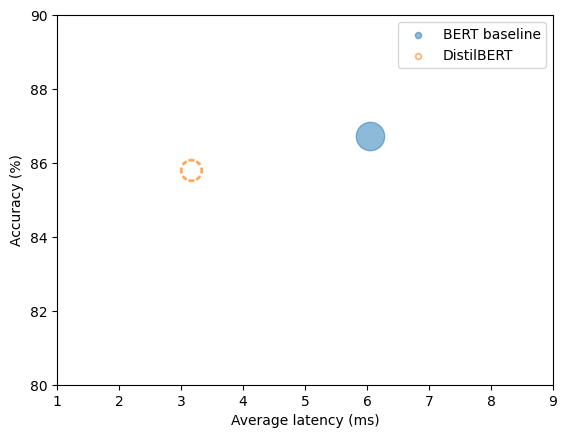

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

### Finding Good Hyperparameters with Optuna

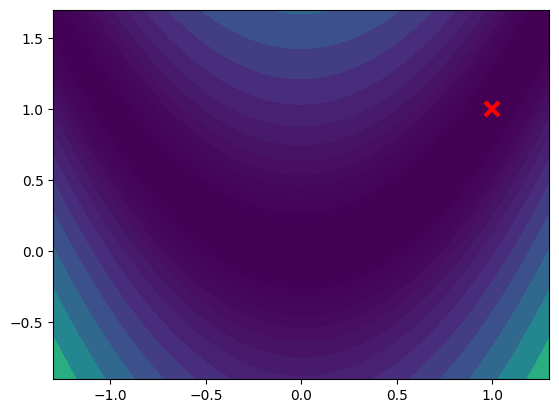

In [34]:
#hide_input
#id banana-function
#alt A banana plot
#caption Plot of the Rosenbrock function of two variables 
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [35]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [36]:
#hide_output
import optuna 

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2025-08-24 05:18:54,288] A new study created in memory with name: no-name-e454d2bc-5cf3-47b8-8c0f-6b6e257312c0
[I 2025-08-24 05:18:54,290] Trial 0 finished with value: 1477.972440390661 and parameters: {'x': -1.8204528383868346, 'y': -0.5200321694244283}. Best is trial 0 with value: 1477.972440390661.
[I 2025-08-24 05:18:54,291] Trial 1 finished with value: 9.002342839177524 and parameters: {'x': -1.2380752228416698, 'y': 1.7326642419135774}. Best is trial 1 with value: 9.002342839177524.
[I 2025-08-24 05:18:54,291] Trial 2 finished with value: 126.89138342300798 and parameters: {'x': 1.5179613438725417, 'y': 1.1789373427487528}. Best is trial 1 with value: 9.002342839177524.
[I 2025-08-24 05:18:54,292] Trial 3 finished with value: 300.82485406987973 and parameters: {'x': 0.42223371394902687, 'y': 1.9117490481179025}. Best is trial 1 with value: 9.002342839177524.
[I 2025-08-24 05:18:54,293] Trial 4 finished with value: 903.7011992172252 and parameters: {'x': -1.847610668114045, 'y'

[I 2025-08-24 05:18:54,317] Trial 14 finished with value: 49.01910765665967 and parameters: {'x': 0.6775174816363434, 'y': 1.1584233371053838}. Best is trial 12 with value: 4.7391439481534405.
[I 2025-08-24 05:18:54,321] Trial 15 finished with value: 608.9460207027572 and parameters: {'x': -0.7388822511660551, 'y': -1.9156019402605677}. Best is trial 12 with value: 4.7391439481534405.
[I 2025-08-24 05:18:54,325] Trial 16 finished with value: 486.22341431511234 and parameters: {'x': -1.4967632926365015, 'y': 0.04943388774742541}. Best is trial 12 with value: 4.7391439481534405.
[I 2025-08-24 05:18:54,329] Trial 17 finished with value: 7.2222330964281705 and parameters: {'x': 1.1224849173394902, 'y': 1.528435246330431}. Best is trial 12 with value: 4.7391439481534405.
[I 2025-08-24 05:18:54,333] Trial 18 finished with value: 855.7523781826684 and parameters: {'x': 1.9395336827176313, 'y': 0.8379754973087907}. Best is trial 12 with value: 4.7391439481534405.
[I 2025-08-24 05:18:54,337] Tr

In [37]:
study.best_params

{'x': 1.0027055974700587, 'y': 1.0057907794840175}

In [38]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [39]:
# #hide_output
# best_run = distilbert_trainer.hyperparameter_search(
#     n_trials=20, direction="maximize", hp_space=hp_space)

In [40]:
# print(best_run)

In [41]:
# #hide_output
# for k,v in best_run.hyperparameters.items():
#     setattr(student_training_args, k, v)
    
# # Define a new repository to store our distilled model
# distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
# student_training_args.output_dir = distilled_ckpt

# # Create a new Trainer with optimal parameters
# distil_trainer = DistillationTrainer(model_init=student_init,
#     teacher_model=teacher_model, args=student_training_args,
#     train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
#     compute_metrics=compute_metrics, tokenizer=student_tokenizer)

# distil_trainer.train();

In [42]:
#hide_output
# distil_trainer.push_to_hub("Training complete")

### Benchmarking Our Distilled Model

In [43]:
distilled_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 3.15 +\- 0.26
Accuracy on test set - 0.868


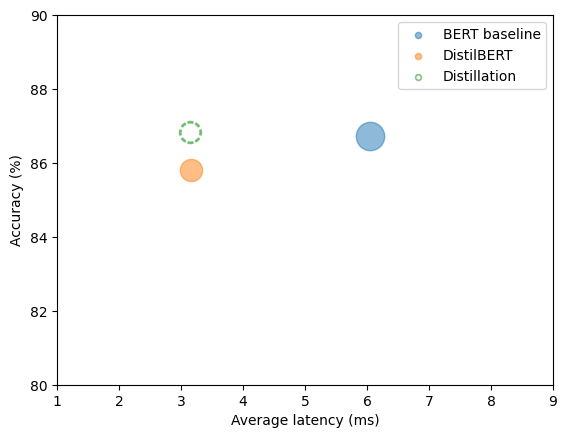

In [44]:
plot_metrics(perf_metrics, optim_type)

## Making Models Faster with Quantization

### Sidebar: A Primer on Floating-Point and Fixed-Point Numbers

### End sidebar

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="images/chapter08_fp32-to-int8.png" id="fp32toint8"/>

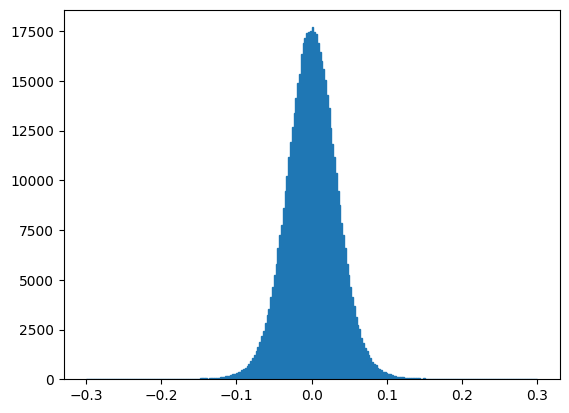

In [45]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().cpu().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [46]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [47]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], device='cuda:0',
       dtype=torch.int8)

In [48]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

tensor([[ -5,  -8,   0,  ...,  -6,  -4,   8],
        [  8,   3,   1,  ...,  -4,   7,   0],
        [ -9,  -6,   5,  ...,   1,   5,  -3],
        ...,
        [  6,   0,  12,  ...,   0,   6,  -1],
        [  0,  -2, -12,  ...,  12,  -7, -13],
        [-13,  -1, -10,  ...,   8,   2,  -2]], device='cuda:0',
       dtype=torch.int8)

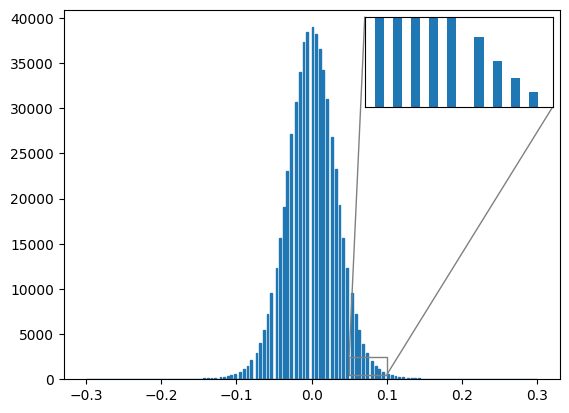

In [49]:
#hide_input
#id weight-quantization
#alt Effect of quantization on a transformer's weights
#caption Effect of quantization on a transformer's weights
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# Create histogram
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().cpu().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# Create zoom inset
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().cpu().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [50]:
%%timeit 
weights @ weights

62.6 µs ± 10.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [51]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [52]:
# エラー
# %%timeit
# q_fn.mul(quantized_weights, quantized_weights)

In [53]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

/tmp/ipykernel_3577432/2099325647.py:3: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())


3.999755879241598

In [54]:
#hide_output
from torch.quantization import quantize_dynamic

model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu").eval())

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

/tmp/ipykernel_3577432/955263440.py:9: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)


### Benchmarking Our Quantized Model

In [55]:
torch.backends.quantized.engine = "fbgemm"  # x86なら
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer, device=-1)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 132.39
Average latency (ms) - 6.49 +\- 0.51
Accuracy on test set - 0.877


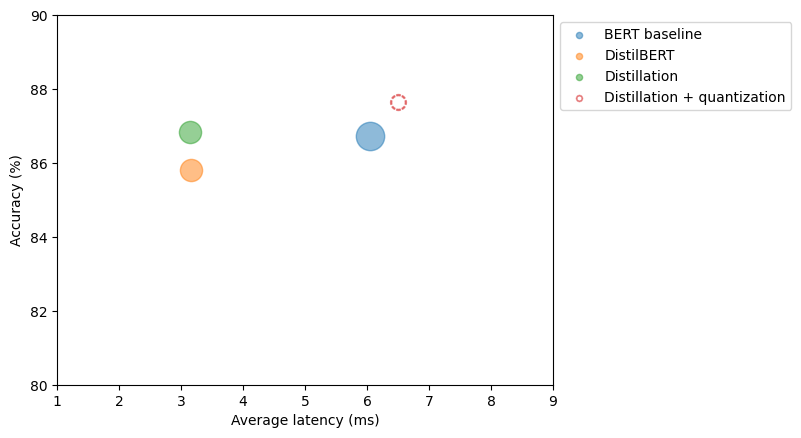

In [56]:
plot_metrics(perf_metrics, optim_type)

## Optimizing Inference with ONNX and the ONNX Runtime

<img alt="Example ONNX graph" width="500" caption="A section of the ONNX graph for BERT-base, visualized in Netron" src="images/chapter08_bert-onnx.png" id="bert-onnx"/>

<img alt="Architecture of the ONNX and ONNX Runtime ecosystem" width="500" caption="Architecture of the ONNX and ONNX Runtime ecosystem (courtesy of the ONNX Runtime team)" src="images/chapter08_onnx-ort.png" id="onnx-ort"/>

In [57]:
#hide_output
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

量子化部分は動かすことできず、、、

In [58]:
# # ✅ エクスポート専用セル（このセルだけを単独で実行）
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = ""   # 変換はCPUで（GPUを不可視化）

# from pathlib import Path
# import torch
# from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
# from optimum.exporters.onnx import export
# from optimum.exporters.tasks import TasksManager

# # --- 入力 ---
# model_ckpt = "transformersbook/distilbert-base-uncased-distilled-clinc"
# onnx_model_path = Path("onnx/model.onnx")
# onnx_model_path.parent.mkdir(parents=True, exist_ok=True)

# # --- モデル/設定（CPUに統一 & eval）---
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)  # なくてもOKだが後で検証に使える
# model = AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu").eval()

# # ★ ここ、変数名を model_ckpt に統一（ckpt ではない）
# hf_config = AutoConfig.from_pretrained(model_ckpt)

# # ONNX用のエクスポート設定を作る
# onnx_config_ctor = TasksManager.get_exporter_config_constructor(
#     model=model, task="text-classification", exporter="onnx",
# )
# onnx_config = onnx_config_ctor(hf_config)

# # --- エクスポート（CPU、opset=13 推奨）---
# export(
#     model=model,
#     config=onnx_config,
#     output=onnx_model_path,
#     opset=13,
#     device="cpu",
#     # use_external_format=False,  # もし外部データ形式になって遅い時は明示
# )

# print("Exported:", onnx_model_path)


In [59]:
# from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
#                          SessionOptions)

# def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
#     options = SessionOptions()
#     options.intra_op_num_threads = 1
#     options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
#     session = InferenceSession(str(model_path), options, providers=[provider])
#     session.disable_fallback()
#     return session

In [60]:
# onnx_model = create_model_for_provider(onnx_model_path)

In [61]:
# inputs = clinc_enc["test"][:1]
# del inputs["labels"]
# logits_onnx = onnx_model.run(None, inputs)[0]
# logits_onnx.shape

In [62]:
# np.argmax(logits_onnx)

In [63]:
# clinc_enc["test"][0]["labels"]

In [64]:
# from scipy.special import softmax

# class OnnxPipeline:
#     def __init__(self, model, tokenizer):
#         self.model = model
#         self.tokenizer = tokenizer
        
#     def __call__(self, query):
#         model_inputs = self.tokenizer(query, return_tensors="pt")
#         inputs_onnx = {k: v.cpu().detach().numpy() 
#                        for k, v in model_inputs.items()}
#         logits = self.model.run(None, inputs_onnx)[0][0, :]
#         probs = softmax(logits)
#         pred_idx = np.argmax(probs).item()
#         return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [65]:
# pipe = OnnxPipeline(onnx_model, tokenizer)
# pipe(query)

In [66]:
# class OnnxPerformanceBenchmark(PerformanceBenchmark):
#     def __init__(self, *args, model_path, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.model_path = model_path
        
#     def compute_size(self):
#         size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
#         print(f"Model size (MB) - {size_mb:.2f}")
#         return {"size_mb": size_mb}

In [67]:
# optim_type = "Distillation + ORT"
# pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
#                               model_path="onnx/model.onnx")
# perf_metrics.update(pb.run_benchmark())

In [68]:
# plot_metrics(perf_metrics, optim_type)

In [69]:
# from onnxruntime.quantization import quantize_dynamic, QuantType

# model_input = "onnx/model.onnx"
# model_output = "onnx/model.quant.onnx"
# quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [70]:
# onnx_quantized_model = create_model_for_provider(model_output)
# pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
# optim_type = "Distillation + ORT (quantized)"
# pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
#                               model_path=model_output)
# perf_metrics.update(pb.run_benchmark())

In [71]:
# plot_metrics(perf_metrics, optim_type)

## Making Models Sparser with Weight Pruning

### Sparsity in Deep Neural Networks

<img alt="Network Pruning" width="500" caption="Weights and neurons before and after pruning (courtesy of Song Han)" src="images/chapter08_network-pruning.png" id="network-pruning"/> 

### Weight Pruning Methods

#### Magnitude pruning

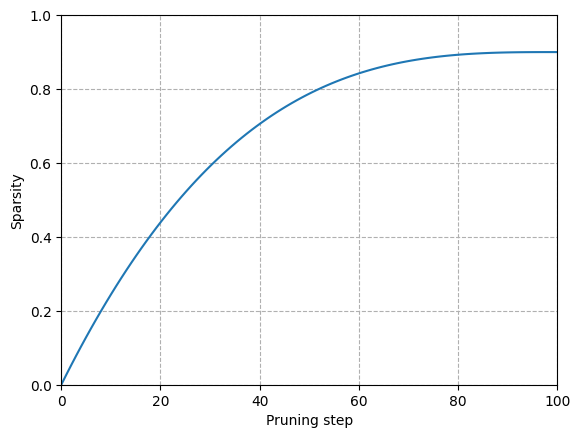

In [72]:
#hide_input
#id sparsity-scheduler
#alt Sparsity scheduler
#caption The cubic sparsity scheduler used for pruning
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

#### Movement pruning

<img alt="Magnitude vs Movement Pruning" width="700" caption="Comparison of weights removed (in gray) during magnitude pruning (left) and movement pruning (right)" src="images/chapter08_magnitude-vs-movement.png" id="magnitude-vs-movement"/> 

<img alt="Pruning Distributions" width="500" caption="Distribution of remaining weights for magnitude pruning (MaP) and movement pruning (MvP)" src="images/chapter08_pruning-dists.png" id="pruning-dists"/>

## Conclusion